<a href="https://colab.research.google.com/github/DrAlexSanz/Real-fake-tweets/blob/bag-words-PCA/Bag_of_words_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is only for cleaning the data. The next ones will do more ML related tasks but this only cleans the data thoroughly. I can see that data cleaning is going to be critical in this one.

# Imports and plumbing

In [54]:
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords #This will in the end be set to english and it will be used as a dictionary of stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer#, TfidVectorizer
from sklearn.model_selection import train_test_split #My old friend XD
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict
from collections import Counter

stop = set(stopwords.words("english"))

import re
import gensim
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Enough with all the imports and dependencies, let's load the data. Now I feel like I'm finally doing something XD.

In [29]:
%cd "/content/drive/My Drive/Tweets"

full = pd.read_csv("clean_dataset.csv", engine = "python")

full.head()

/content/drive/My Drive/Tweets


,Unnamed: 0,id,keyword,location,text,target,length
0,0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1.0,69
1,1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1.0,38
2,2,5,NaN,NaN,All residents asked to shelter in place are be...,1.0,133
3,3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1.0,65
4,4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1.0,88


In [0]:
def create_corpus_df(df, target):
    
    corpus = []
    
    for x in df[df["target"] == target]["text"].str.split():
        for i in x:
            corpus.append(i)
            
    return corpus

# Bag of words

In [31]:
#Start with fake disaster tweets

corpus_fake = create_corpus_df(full, 0.)

print(corpus_fake[:10])
print(r"Fake corpus length is", len(corpus_fake))

['Whats', 'up', 'man', 'I', 'love', 'fruits', 'Summer', 'is', 'lovely', 'My']
Fake corpus length is 62679


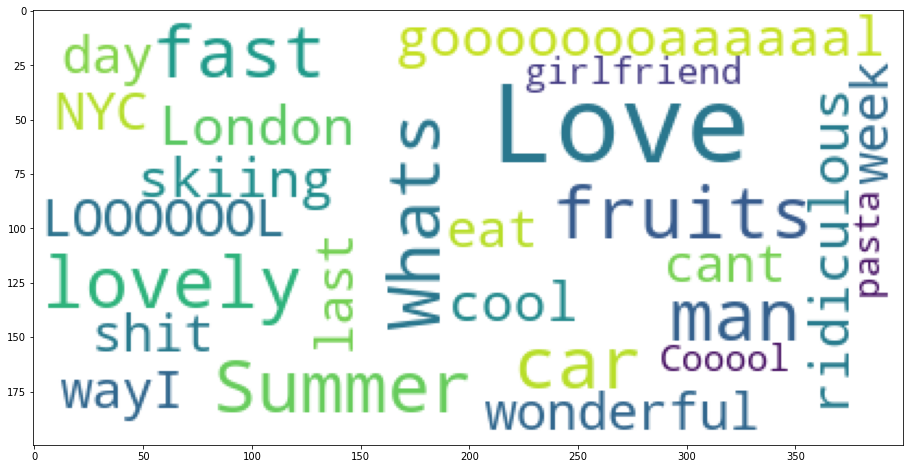

In [32]:
plt.figure(figsize = (16, 8))

word_cloud_fake = WordCloud(background_color = "white",
                            max_font_size = 50).generate(" ".join(corpus_fake[:50]))
plt.imshow(word_cloud_fake);

Now let's compare this word cloud wit the other one.

In [33]:
corpus_real = create_corpus_df(full, 1.)

print(corpus_real[:10])
print(r"Real corpus length is", len(corpus_real))

['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', 'earthquake', 'May', 'ALLAH']
Real corpus length is 48780


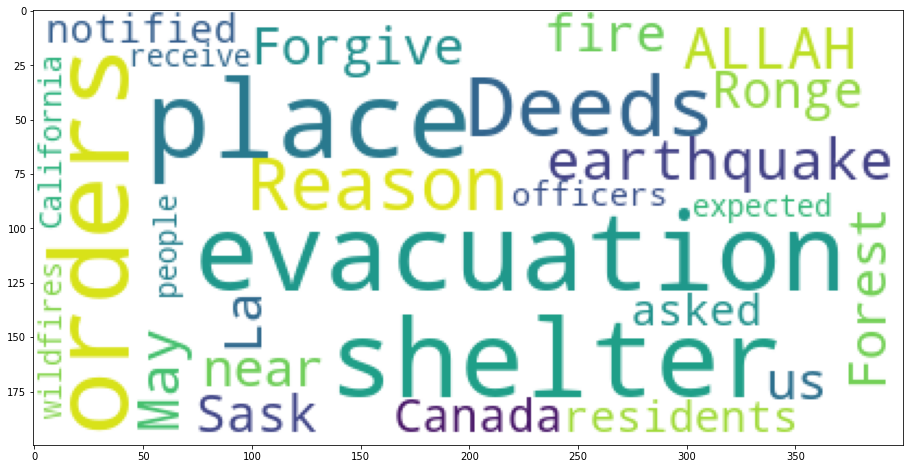

In [34]:
plt.figure(figsize = (16, 8))

word_cloud_real = WordCloud(background_color = "white",
                            max_font_size = 50).generate(" ".join(corpus_real[:50]))
plt.imshow(word_cloud_real);

The real disaster tweets have way different words. This is a good thing. It tells me just by frequency counting could be a decent start. I can then complicate it as much as I want but I can start with a logistic classifier or some simple function and I will get somehow decent accuracy.

In [0]:
def count_vect(x):
    """This function does the count vectorizer part of preprocessing
       This function also does the embedding (fit + transform)

        From sklearn docs (CountVectorizer):
        Convert a collection of text documents to a matrix of token counts

        This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.

    """

    count_vectorizer = CountVectorizer() # Empty because I don't want tokenization or anything else

    embedding = count_vectorizer.fit_transform(x) # Fit transform is a great invention

    return embedding, count_vectorizer



In [44]:
list_corpus = full["text"].tolist()
list_labels = full["target"].tolist() #Quick way of getting things out of a df

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels,
                                                    test_size = 0.2,
                                                    random_state = 13)
X_train_counts, vect = count_vect(X_train)
X_test_counts = vect.transform(X_test)

print(X_train_counts.shape) # 8700 is the length, 24768 is the vector components (words)
print(len(y_train))
print(X_test_counts.shape)
print(len(y_test)) #8700 + 2176 amount to almost 10.000 tweets

(8700, 24768)
8700
(2176, 24768)
2176


# Visualize the SVD (PCA) projections. Perhaps I see something useful. Also TSNE.

  ## SVD

The PCA from sklearn is for dense input, not sparse. PCA uses SVD, but a dense implementation. They use this even here but they call it LSA (latent semantic allocation, see the book I have).

I'm going to create calculate + plot functions. Like this everything is in the same place.

In [0]:
def calc_plot_LSA(data, labels, plot_result = True):

    """
        This function takes the train dataset, calculates the SVD projections and plots it in nice colours (hopefully brown).
    
    """

    lsa = TruncatedSVD(n_components = 2, n_iter = 5) # I want to plot. 3 is also good but no one understands 3D scatter plots

    lsa.fit(data)
    lsa_comp = lsa.transform(data)

    color_map = {label: idx for idx, label in enumerate(set(labels))}

    color_column = [color_map[label] for label in labels]
    colors = ["red", "blue"]

    if plot_result:
        plt.figure(figsize = (16, 16))
        plt.scatter(lsa_comp[:, 0], lsa_comp[:, 1], s = 8, alpha = 0.8, c = labels,
                    cmap = matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color = "red", label = "Fake")
        blue_patch = mpatches.Patch(color = "blue", label = "Real")
        plt.legend(handles = [red_patch, blue_patch])

    #I don't return anything here



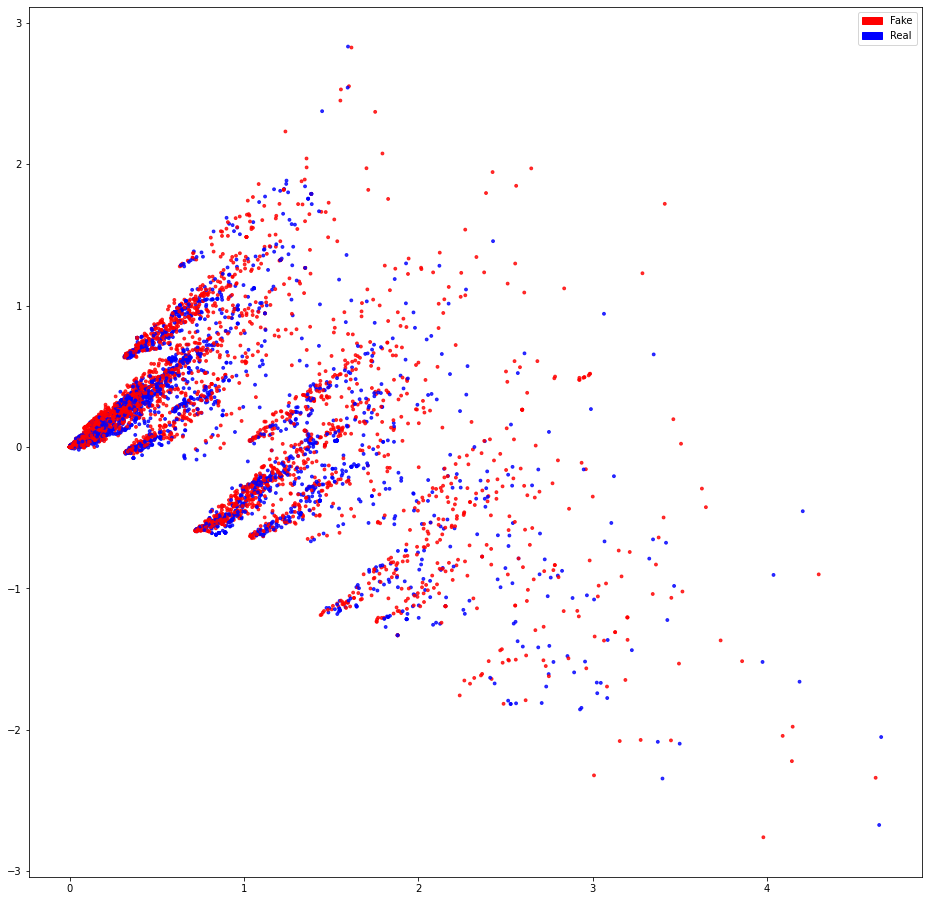

In [68]:
calc_plot_LSA(X_train_counts, y_train)

Not a very clean separation that I can see. Let's see TSNE. TSNE doesn't conserve distances and all that, but it's cool and I want to see it. I guess it's not that useful having word embeddings, but let's do it.

## TSNE